In [3]:
"""
Construct heatmaps of different gene families
"""

import sys
import pandas as pd
import numpy as np
import scipy
from matplotlib.collections import LineCollection
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

### Heatmaps

In [81]:
def gene_ids_from_annotation(gene_annot_df, annotation):
    if isinstance(annotation, list):
        gene_list = np.array([])
        if annotation[0].startswith("GO"):
            for go in annotation:
                ids = gene_annot_df.query(f"GO_terms.str.contains('{go}', na=False)", engine='python')['gene_id'].to_numpy()
                gene_list = np.hstack([gene_list, ids])
            return(np.unique(gene_list))
        else:
            for dom in annotation:
                ids = gene_annot_df.query("domain == @annotation")['gene_id'].to_numpy()
                gene_list = np.hstack([gene_list, ids])
            return(np.unique(gene_list))
    else:
        if annotation.startswith("GO"): 
            return(gene_annot_df.query(f"GO_terms.str.contains('{annotation}', na=False)", engine='python')['gene_id'].to_numpy())
        else:
            return(gene_annot_df.query("domain == @annotation")['gene_id'].to_numpy())

In [6]:
metadata = pd.read_csv("../../config/sample_metadata.tsv", sep="\t")
# load metadata
metadata = pd.read_csv("https://raw.githubusercontent.com/sanjaynagi/rna-seq-meta/main/config/comparison_metadata.tsv", sep="\t")  
# load fold change data and remove gene description column
fc_data = pd.read_csv("https://raw.githubusercontent.com/sanjaynagi/rna-seq-meta/main/results/fc_data.tsv", sep="\t") 

In [63]:
gene_identifier = 'p450'

In [78]:
def plot_heatmap(gene_identifier, figsize=None):
    
    pfam_df = pd.read_csv("https://github.com/sanjaynagi/rna-seq-meta/blob/main/resources/Anogam_long.pep_Pfamscan.seqs.gz?raw=true", sep="\s+", header=None, compression='gzip')
    go_df = pd.read_csv("https://github.com/sanjaynagi/rna-seq-meta/blob/main/resources/Anogam_long.pep_eggnog_diamond.emapper.annotations.GO.gz?raw=true", sep="\t", header=None, compression='gzip')
    pfam_df.columns = ["transcript", "pstart", "pend", "pfamid", "domain", "domseq"]
    go_df.columns = ['transcript', 'GO_terms']

    gene_annot_df = pfam_df.merge(go_df)
    gene_annot_df.loc[:, 'gene_id'] = gene_annot_df.loc[:, 'transcript'].str.replace("Anogam_", "").str.replace("-R[A-Z]", "", regex=True)

    # load metadata
    fc_data = pd.read_csv("https://raw.githubusercontent.com/sanjaynagi/rna-seq-meta/main/results/fc_data.tsv", sep="\t") 
    
    gene_ids = gene_ids_from_annotation(gene_annot_df, gene_identifier)
    fam_data = fc_data.query("GeneID in @gene_ids")
    assert not fam_data.empty, "No genes were found for the selection. It is possible these genes were removed by the ortholog finding process"
    
    fam_data.loc[:, 'Label'] = [id_ + " | " + name if name != "" else id_ for id_, name in zip(fam_data['GeneID'].fillna(""), fam_data['GeneName'].fillna(""))]
    fam_data = fam_data.set_index("Label").drop(columns=['GeneName', 'GeneID', 'GeneDescription'])
    fam_data.columns = [c.replace("_log2FoldChange", "").replace("_", " ") for c in fam_data.columns]
    mask = fam_data.isnull()
    
    if not figsize:
        height = fam_data.shape[0] / 4
        figsize = [10, height]

    cg = sns.clustermap(
        fam_data.fillna(0), 
        mask=mask, 
        cbar_pos=None, 
        figsize=figsize, 
        tree_kws={'linewidths':3, 'colors':'darkgrey'},
        linewidths=2,
        yticklabels=True,
    )

    cg.ax_col_dendrogram.set_visible(False)

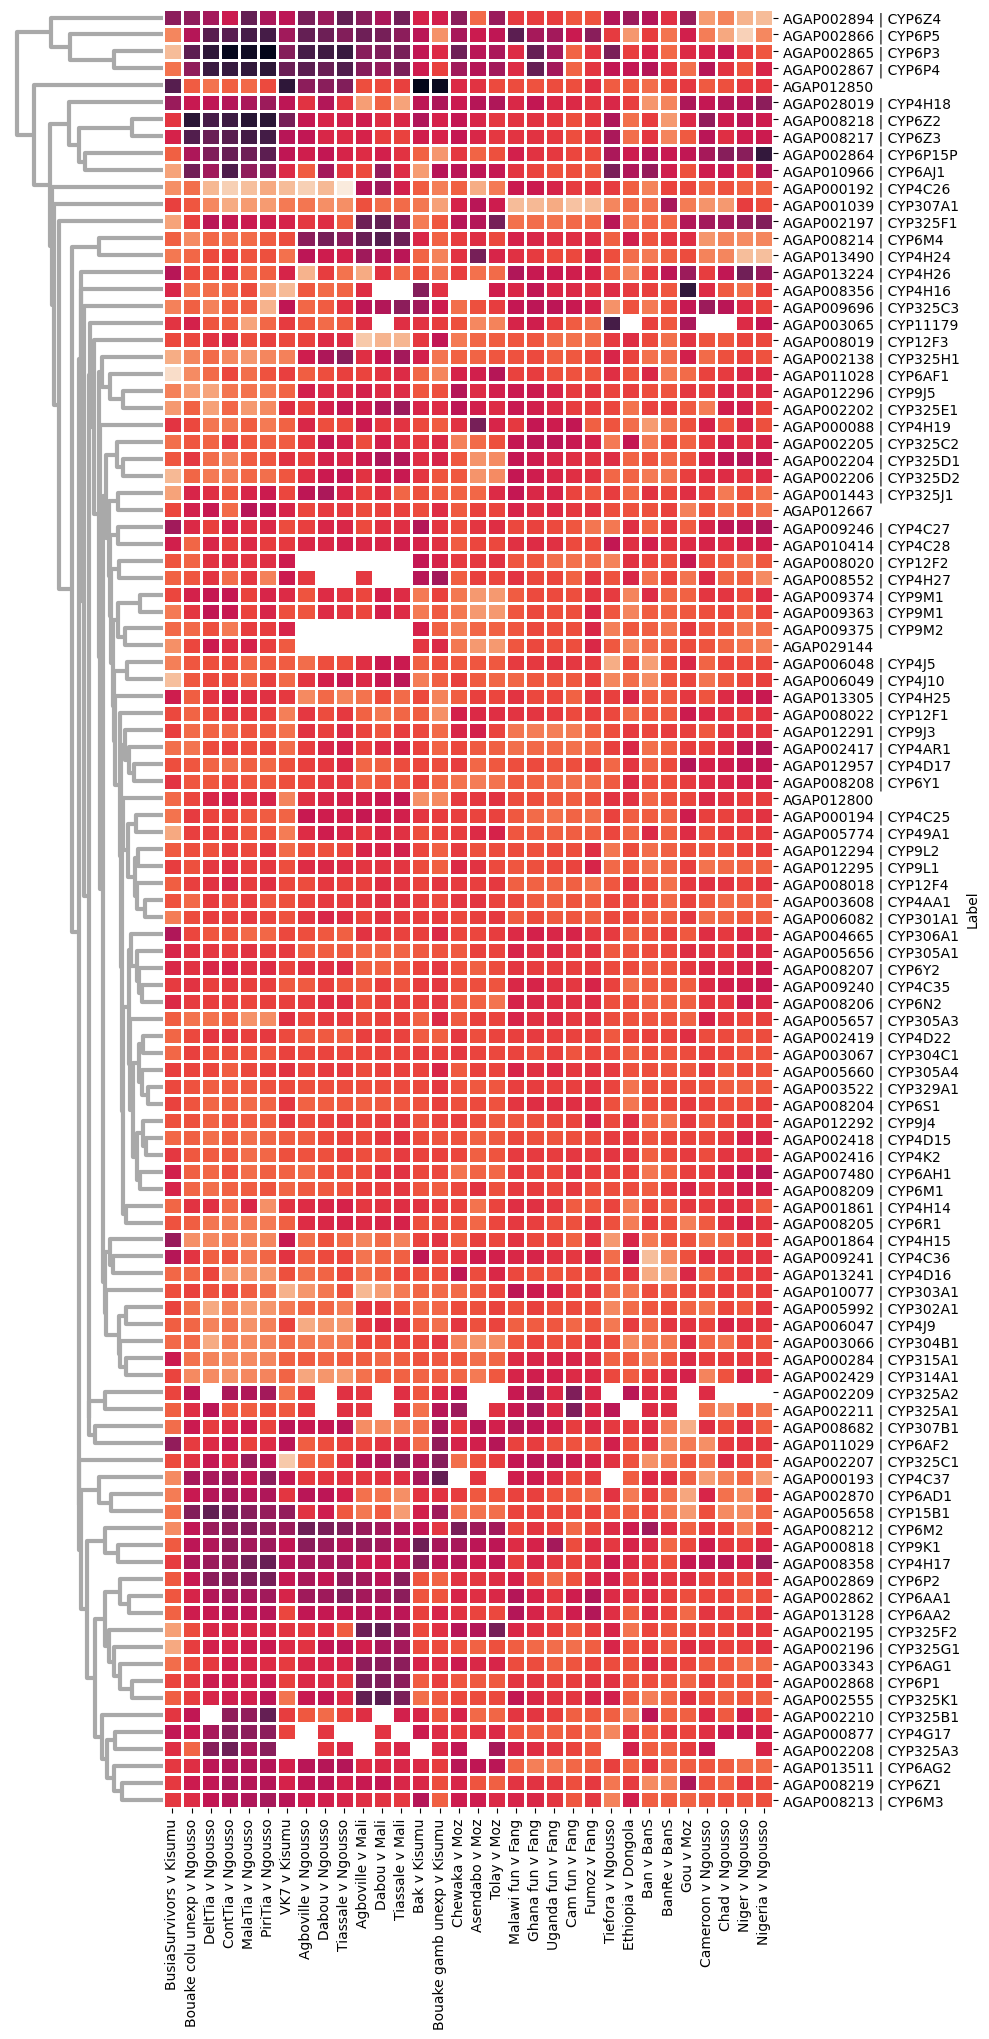

In [75]:
plot_heatmap(gene_identifier='p450')

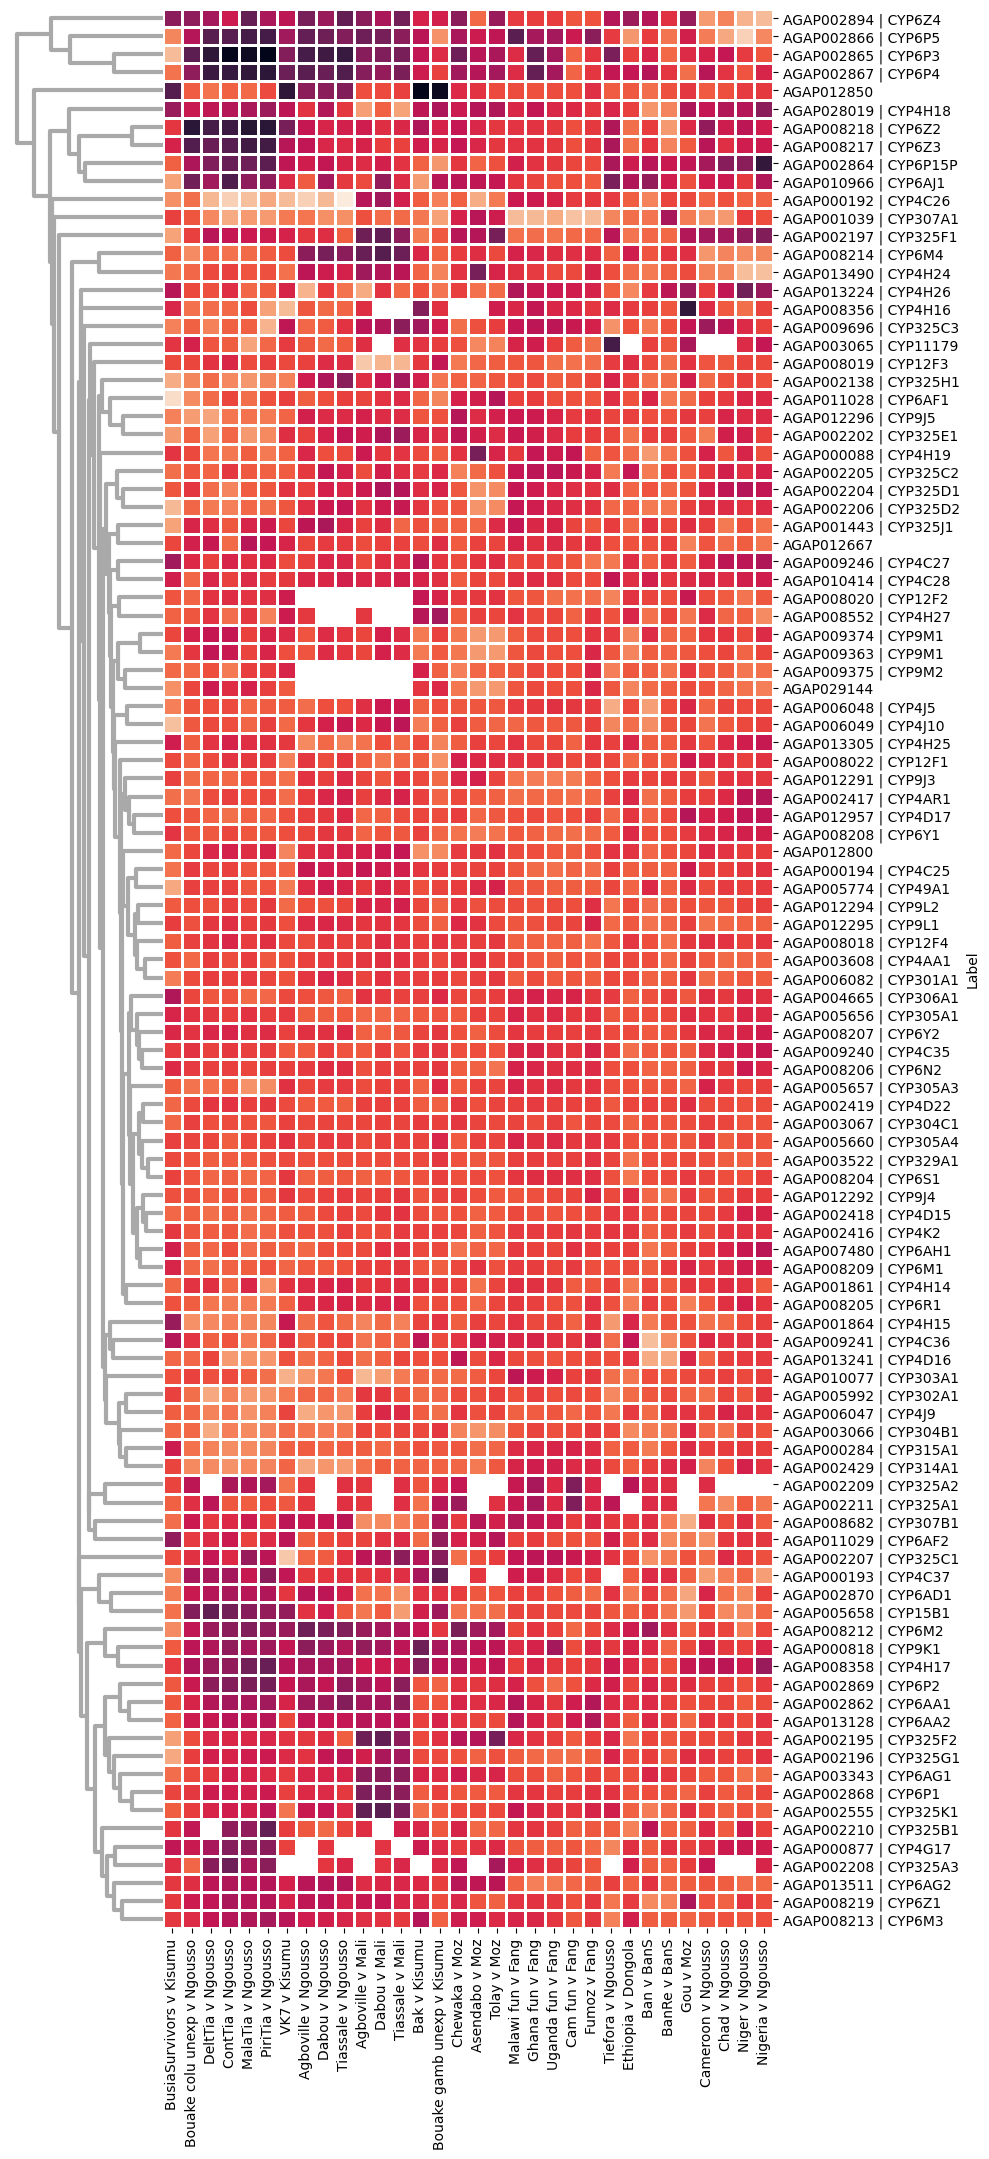

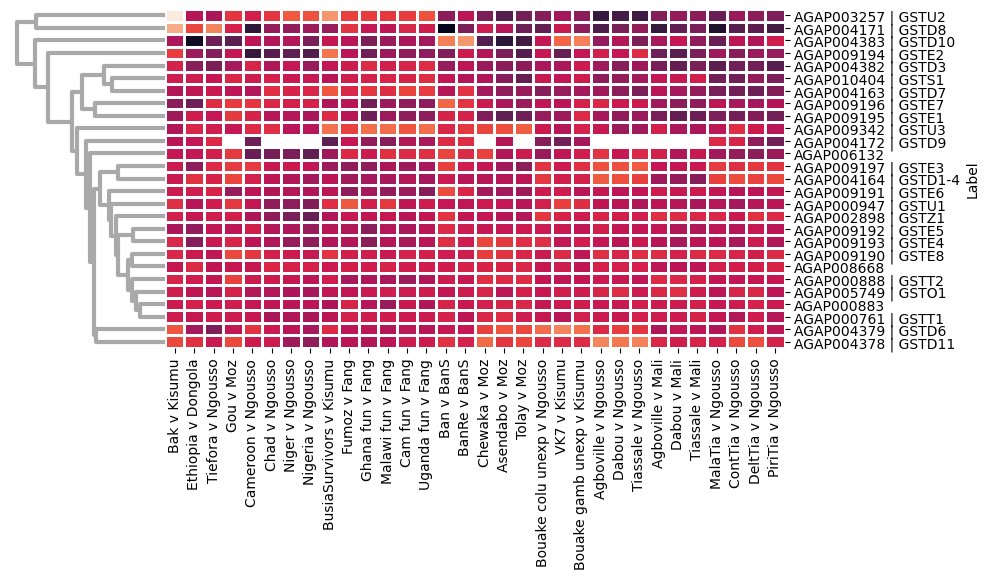

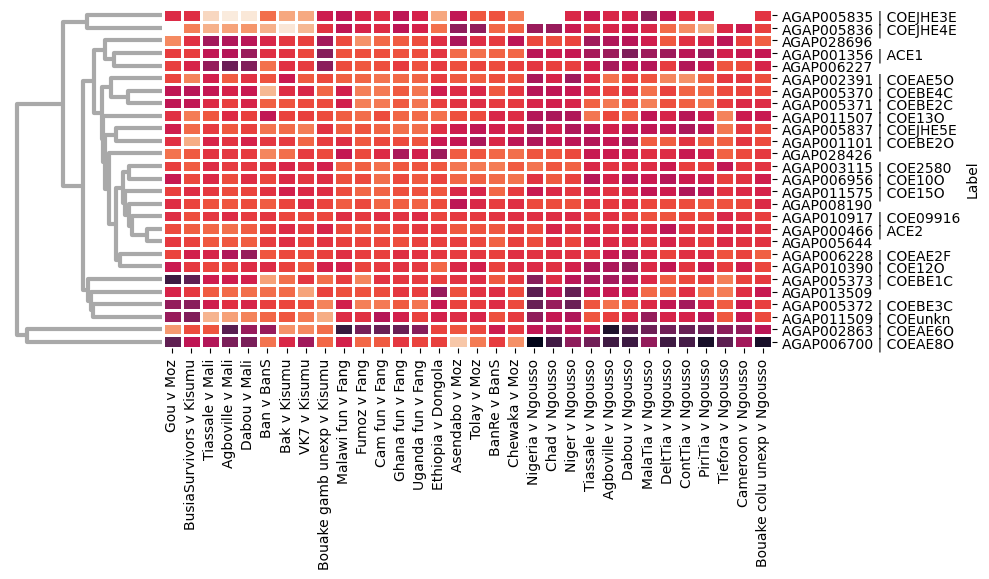

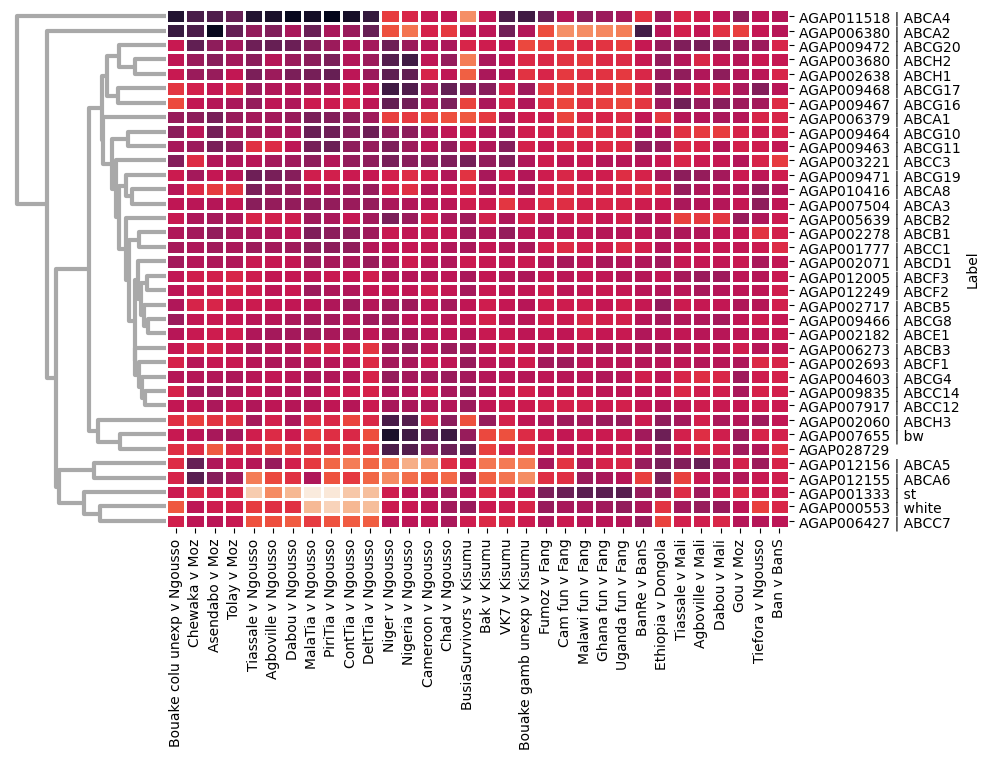

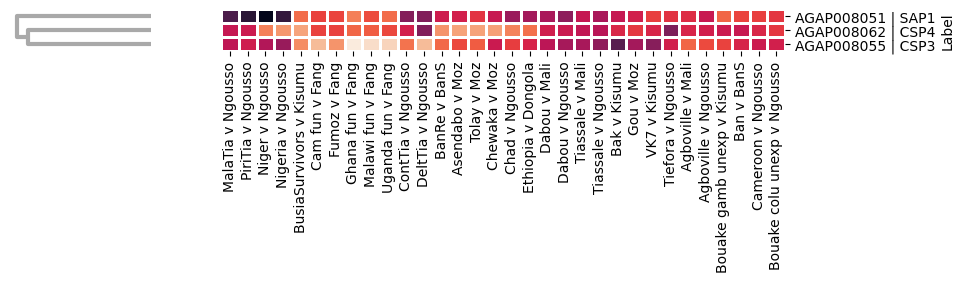

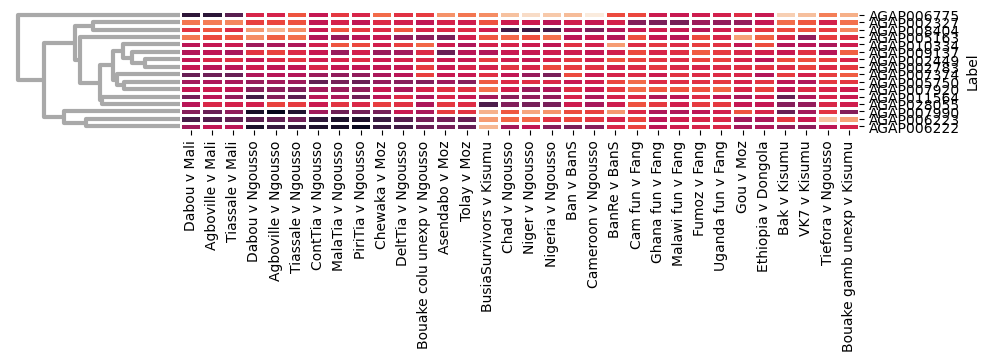

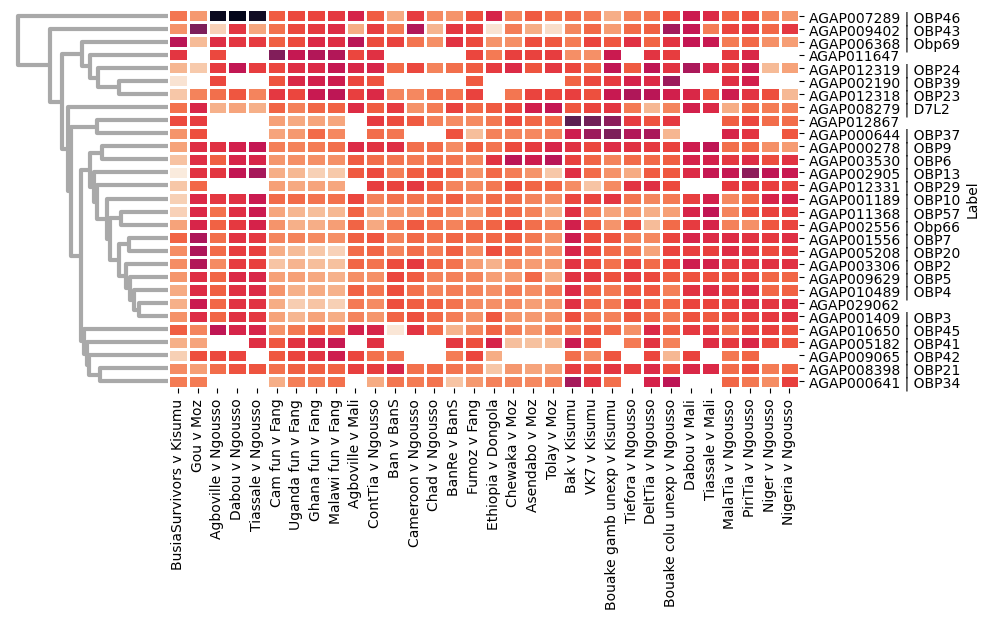

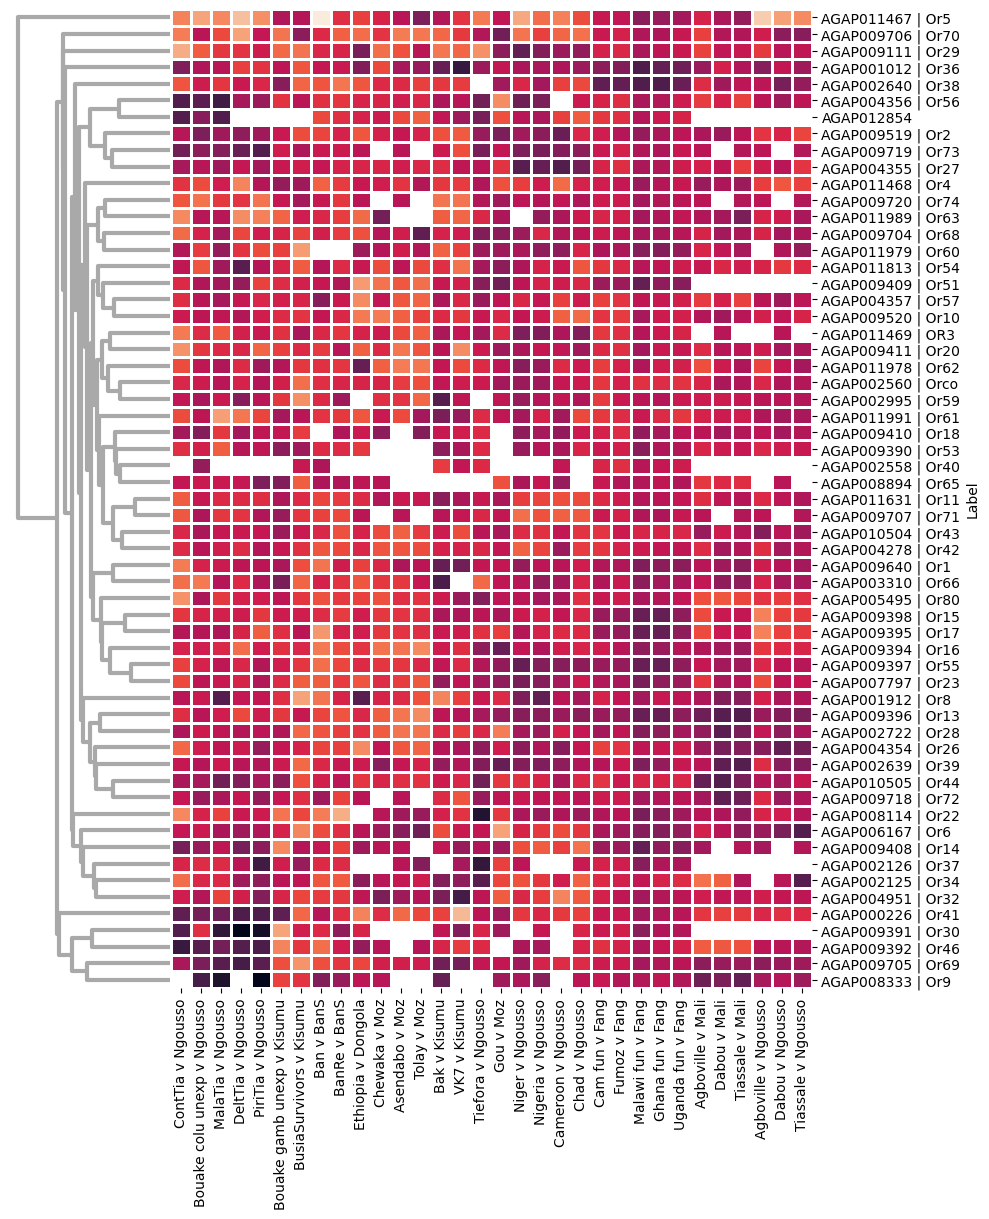

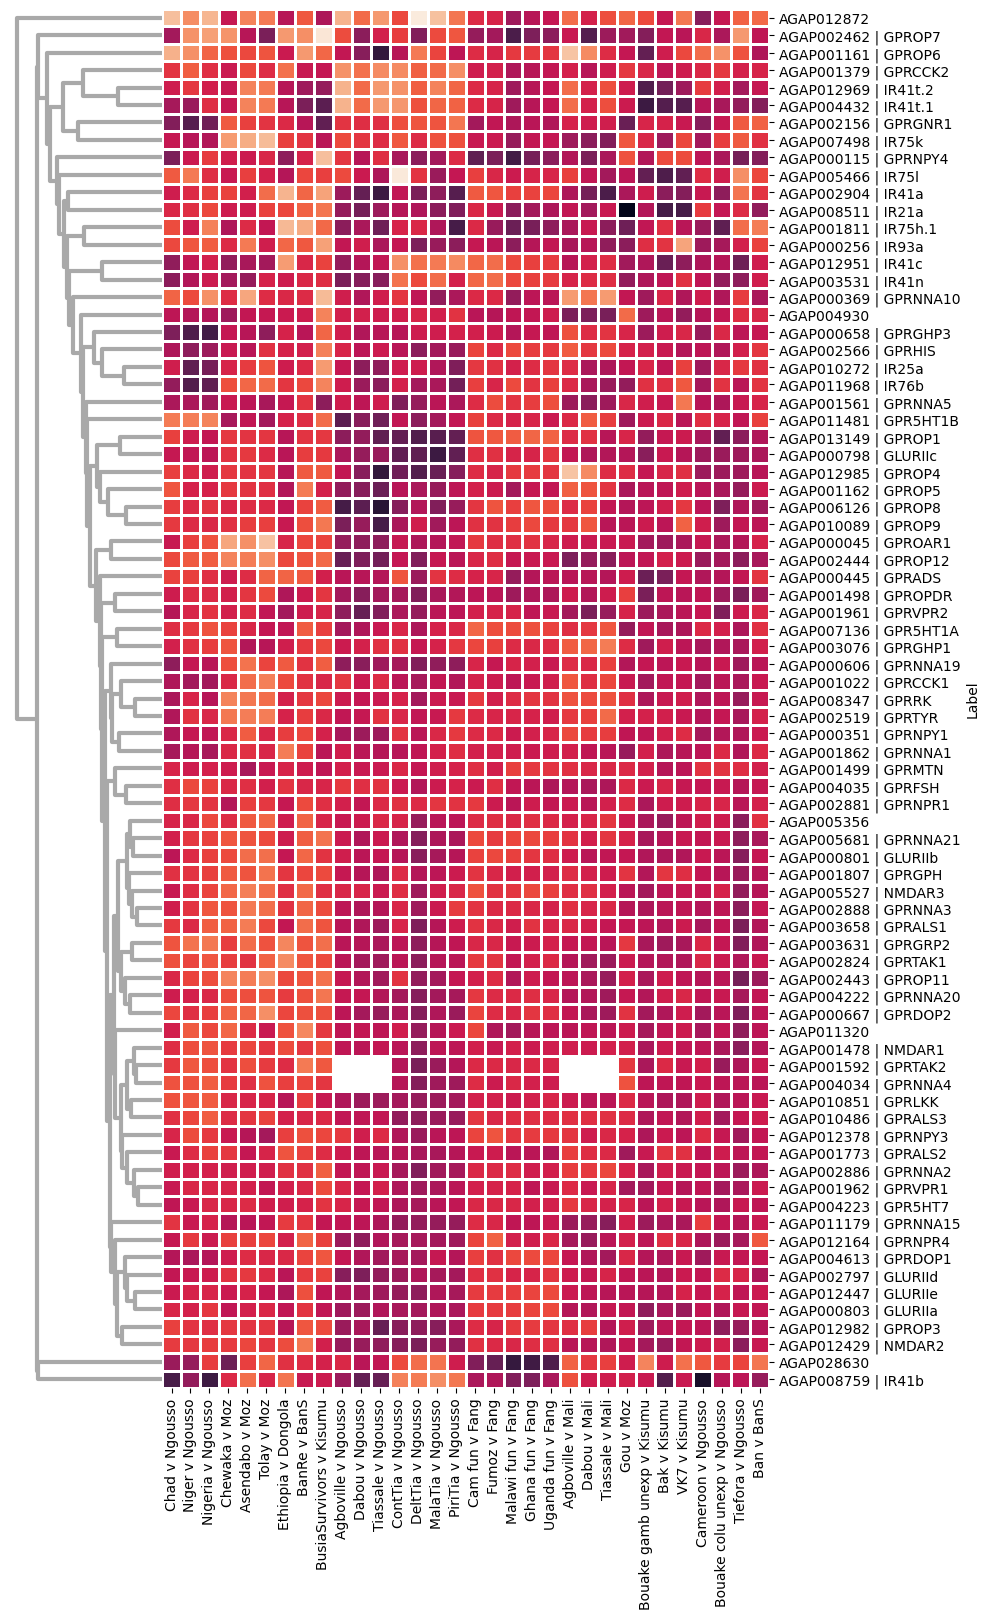

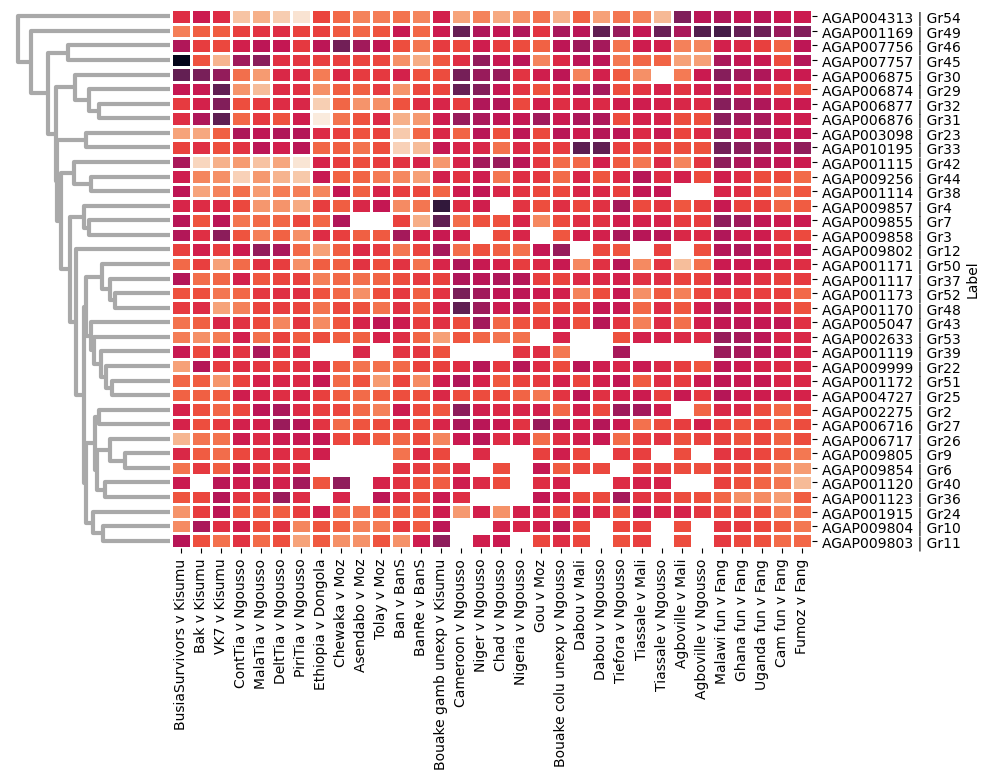

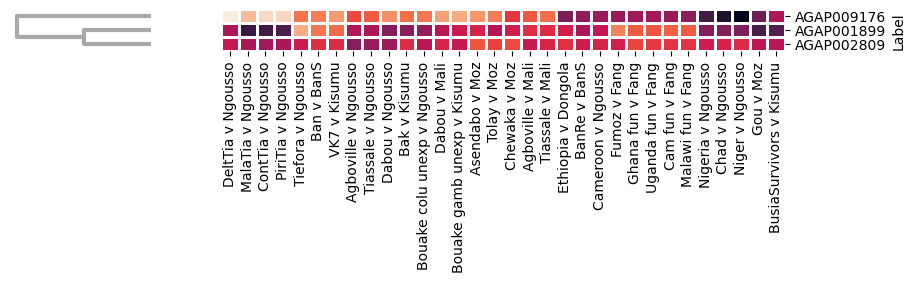

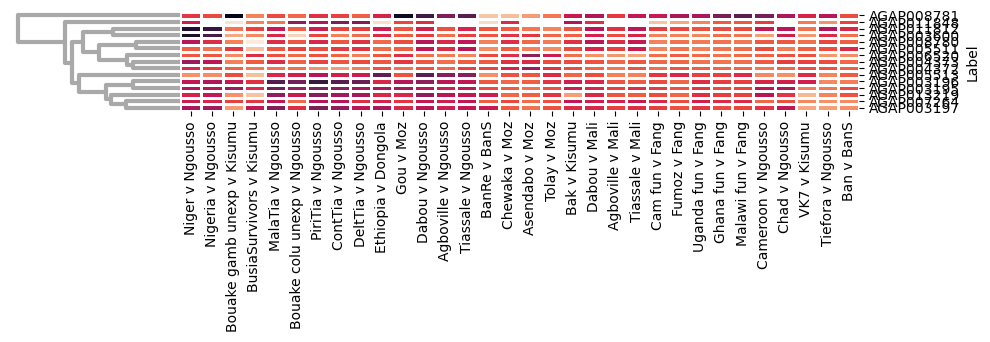

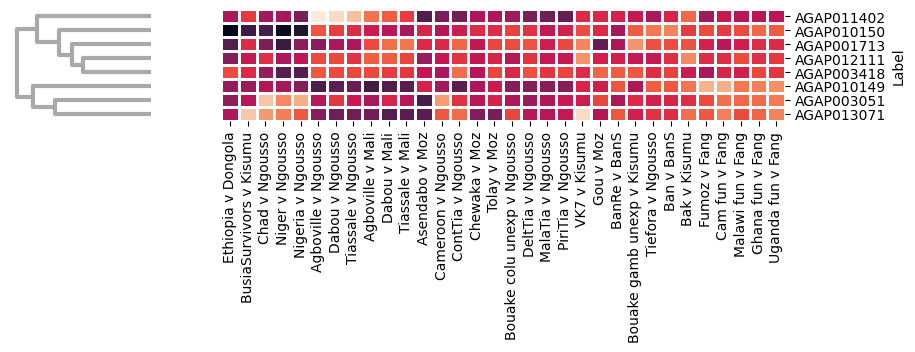

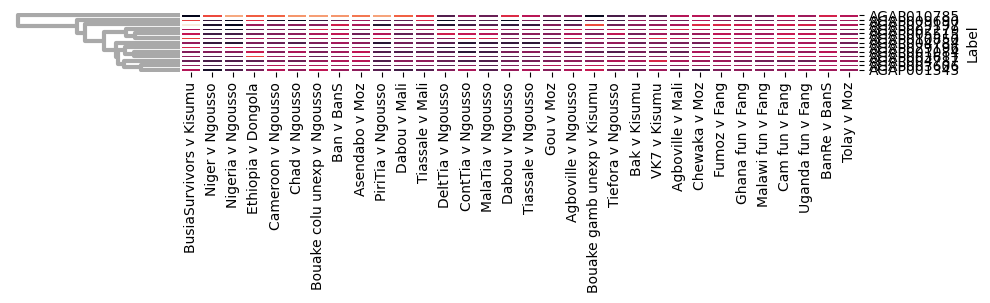

In [80]:
# a dict with gene families and their respective Pfam domain for extracting
gene_fams = {'Cytochrome P450s':'p450', 
             'GSTs':['GST_N', 'GST_N_3', 'GST_C'], 
             'Carboxylesterases': 'COesterase', 
             'ABC-transporters':['ABC_membrane', 'ABC_tran'],
             'CSP': 'OS-D',
             'UGTs': 'UDPGT',
             'Odorant binding proteins':'PBP_GOBP', 
             'Olfactory receptors':'7tm_6', 
             'Ionotropic receptors':['Lig_chan','7tm_1'],
             'Gustatory receptors': '7tm_7',
             'Fatty acid synthases':'ketoacyl-synt',
             'FA Elongase':'ELO',
             'FA desaturase':'FA_desaturase',
             'FA reductase':'NAD_binding_4',
             }

for fam, fam_id in gene_fams.items():

    plot_heatmap(gene_identifier=fam_id)